# Real data comparison

In [1]:
%pylab inline

import scipy.sparse
import pandas as pd
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance

from regain import datasets; reload(datasets)
from regain import model_selection; reload(model_selection)
from regain.plot import plot_graph_with_latent_variables
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.utils import error_norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_excel("/home/fede/Desktop/inline-supplementary-material-2.xls", skiprows=1, index_col=0)
best_dims = pd.read_csv("/home/fede/Desktop/inline-supplementary-material-3.txt", delimiter="\t",
                            skiprows=[0,2], skipinitialspace=True)

In [3]:
df.columns = df.columns.str.lower()

In [4]:
best_dims['sum_abs_diff_stress'] = (np.abs(best_dims['cold_2'] - best_dims['cold_3']) + 
    np.abs(best_dims['heat_2'] - best_dims['heat_3']) +
    np.abs(best_dims['oxidative_2'] - best_dims['oxidative_3']))

In [5]:
dims = best_dims.sort_values("sum_abs_diff_stress", ascending=False).head(10)['condition_timepoint'].tolist()

In [6]:
for x in ['shikimic acid-3-phosphate', "methionine", '2-ketobutyric acid']:
    try:
        dims.remove(x)
    except:
        pass

In [7]:
df_reduced = df.loc[:,['time point', 'stress'] + dims].fillna(1)

In [8]:
df_reduced = df_reduced[df_reduced.stress.isin(['cold stress', 'heat stress', 'oxidative stress'])]

In [9]:
a3d = np.array(list(df.groupby("time point").apply(pd.DataFrame.as_matrix)))

df_group = df_reduced.groupby("time point")
max_timepoints = 12
# df_group = df_group.fillna(0)
min_size = int(np.min([g[dims].values.shape[0] for n, g in df_group if n < max_timepoints]))
X = np.array([group[dims].values[:min_size] for name, group in df_group if name < max_timepoints], dtype=float)
# for name, group in df_group:
#     print group.values.astype(float)

In [11]:
data_list = np.log(X.copy())
data_grid = data_list.transpose(1,2,0)

In [49]:
X.shape

(6, 26, 7)

In [31]:
mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-4, tol=1e-4, psi='node', phi='node',
    max_iter=350, rho=1./ np.sqrt(np.array(data_list).shape[1]))

# alpha=np.linspace(0.01, 0.2, 5)
# tau=np.linspace(0.01, 0.8, 5)
# beta=np.linspace(0.01, 0.8, 2)
# eta=np.linspace(0.01, 0.8, 2)
# params = dict(tau=tau, eta=eta, alpha=alpha, beta=beta)

# ltgl = GridSearchCV(mdl, params, cv=ShuffleSplit(3, test_size=.5), verbose=True).fit(data_grid)

domain = [
    {'name': 'tau', 'type': 'continuous', 'domain': (-1,0)},
    {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
    {'name': 'beta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
    {'name': 'eta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
]
ltgl = model_selection.BayesianOptimization(
    mdl, domain=domain, n_jobs=2, acquisition_weight=1, acquisition_jitter=.01,
    acquisition_type='EI', max_iter=200, cv=ShuffleSplit(5, test_size=.1)).fit(data_grid)

alpha = ltgl.best_params_['alpha']
tau = ltgl.best_params_['tau']
beta = ltgl.best_params_['beta']
eta = ltgl.best_params_['eta']

tic = time.time()
# ll = ltgl.best_estimator_.fit(data_grid)
ll = mdl.set_params(**ltgl.best_params_).set_params(max_iter=500).fit(data_grid)
tac = time.time()

([<matplotlib.axis.XTick at 0x7f55d75f7c50>,
 <a list of 5 Text xticklabel objects>)

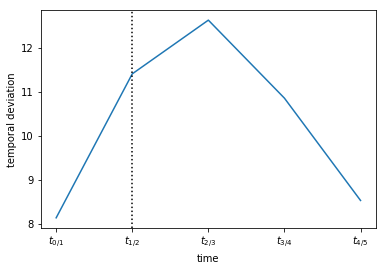

In [75]:
mat = ll.precision_
f = plt.figure()
plt.plot([np.linalg.norm(mat[i+1] - mat[i]) for i in range(mat.shape[0]-1)])
plt.axvline(1, ls=':', c='k')
plt.ylabel("temporal deviation");
plt.xlabel("time");
plt.xticks(np.arange(mat.shape[0]-1),
           [r'$t_{%d/%d}$'%(i,i+1) for i in range(mat.shape[0]-1)])
# plt.xticks()

In [76]:
f.savefig("/home/fede/Dropbox/Latent variables networks/paper formatted/real_data_temporal_deviation.pdf")

In [2]:
data = pd.read_csv("/home/fede/src/slipguru/regain/regain/data/finance.csv", header=0, index_col=0)

In [16]:
data.loc[:, ['A', 'AA']][10:12]

,A,AA
20090904,1.22,0.38
20090909,3.87,4.05


In [48]:
n = 30
data_list = np.array([data.loc[:,['AMZN', 'IBM', 'GOOG', 'MSFT','APOL']][i:i+n].values 
             for i in range(1, data.shape[0], n)][:-1])

In [60]:
[data.loc[:,['AMZN', 'IBM', 'GOOG', 'MSFT','APOL']][i:i+n] 
             for i in range(1, data.shape[0], n)][:-1]

[          AMZN   IBM  GOOG  MSFT  APOL
 20090824 -0.62 -0.52  0.72  0.91 -0.47
 20090825 -0.68 -0.73  0.25 -0.32  1.43
 20090826 -0.27  0.49 -0.76 -0.41  0.88
 20090827 -0.02 -0.42 -0.80  0.18  0.97
 20090828 -1.46 -0.63  0.10  0.34  0.92
 20090831 -1.39  0.36 -0.16  0.38 -3.52
 20090901 -0.55  0.80  0.68 -0.68  0.09
 20090902 -0.97 -0.19 -0.28 -0.26  1.37
 20090903 -0.28 -0.48  0.31  0.36  1.77
 20090904 -0.51 -0.06 -0.21  1.08 -1.50
 20090909  3.15 -1.72 -0.54 -0.47  0.49
 20090910  1.12 -0.06  0.66  0.05  0.16
 20090911  1.05  0.55  0.48 -0.33 -1.90
 20090914 -1.03  0.48  0.41  0.34  0.89
 20090915 -0.96 -0.19 -0.08  0.21  1.06
 20090916  7.44  0.95  1.13 -1.12 -1.50
 20090917 -0.21  0.13  0.78  0.48  2.79
 20090918 -0.55 -0.18 -0.42 -0.53 -0.73
 20090921  0.73 -0.02  1.55  0.58  8.71
 20090922  3.00 -0.49 -0.11  1.34 -5.10
 20090923 -0.63  0.18  0.71  0.59 -0.31
 20090924  0.13  0.52  0.08  1.32  0.42
 20090925 -1.29  0.55 -0.43 -1.07  0.63
 20090928  0.58 -2.73 -0.06 -0.19 -0.69


In [55]:
data_grid = data_list.transpose(1,2,0)

In [56]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain.admm import latent_time_graph_lasso_v3_; reload(latent_time_graph_lasso_v3_);

mdl = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1. / np.array(data_list).shape[1])

ltgl = GridSearchCV(mdl, dict(#tau=[0.25, 0.2, 0.1],
                             tau=np.linspace(0.01, 0.8, 20),
                             eta=[0], beta=[0],
                             #alpha=[0.05, 0.1, 1],
                             alpha=np.linspace(0.01, 0.2, 5)),
                    cv=ShuffleSplit(1, test_size=.5)).fit(data_grid)

In [58]:
ltgl.best_estimator_.precision_

array([[[ 0.2663739 , -0.        , -0.        , -0.        ,  0.        ],
        [-0.        ,  0.98324308, -0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  1.41211198, -0.        , -0.01293394],
        [-0.        , -0.        , -0.        ,  0.96868926, -0.        ],
        [ 0.        ,  0.        , -0.01293394, -0.        ,  0.17808471]],

       [[ 0.06496547, -0.        , -0.        , -0.09513111,  0.        ],
        [-0.        ,  0.58114476,  0.        ,  0.        ,  0.        ],
        [-0.        ,  0.        ,  0.49464878,  0.        , -0.        ],
        [-0.09513111,  0.        ,  0.        ,  0.53323127, -0.        ],
        [ 0.        ,  0.        , -0.        , -0.        ,  0.08861144]],

       [[ 0.27226079, -0.        , -0.        , -0.        ,  0.        ],
        [-0.        ,  1.10773215, -0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.72082331, -0.        ,  0.        ],
        [-0.        ,

In [ ]:
['AMZN', 'IBM', 'GOOG', 'MSFT','APOL']